In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.metrics import r2_score

from dataset_paths import Paths


In [2]:
df = pd.read_csv(Paths.OHE / "combined-data.csv")

df.head()


,Year,Temperature,Co2,Country_Albania,Country_Algeria,Country_Angola,Country_Anguilla,Country_Antigua and Barbuda,Country_Argentina,Country_Australia,...,Country_Uganda,Country_United Arab Emirates,Country_United Kingdom,Country_United States,Country_Uruguay,Country_Vanuatu,Country_Vietnam,Country_Western Sahara,Country_Zambia,Country_Zimbabwe
0,1970,0.248,8.952570,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1970,0.082,0.002168,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1970,-0.106,4.814516,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1970,0.422,19.437564,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,1970,0.438,88.321009,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
avg_by_year = df.groupby('Year').mean()

X = avg_by_year[['Co2']].values
y = avg_by_year['Temperature'].values

split_index = int(len(X) * 0.8)

X_train, X_val_test = X[:split_index], X[split_index:]
y_train, y_val_test = y[:split_index], y[split_index:]


split_index_val = int(len(X_val_test) * 0.5)

X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


seq_length = 3
tf.random.set_seed(42)

train_ds = keras.utils.timeseries_dataset_from_array(
    X_train,
    targets = y_train[seq_length:],
    sequence_length= seq_length,
    batch_size = 5,
    shuffle = True,
    seed = 42
)

valid_ds = keras.utils.timeseries_dataset_from_array(
    X_val,
    targets= y_val[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)
test_ds = keras.utils.timeseries_dataset_from_array(
    X_test,
    targets= y_test[seq_length:],
    sequence_length = seq_length,
    batch_size = 5
)


In [4]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=100):
  early_stopping_cb = keras.callbacks.EarlyStopping(
      monitor = "val_mae", patience = 50, restore_best_weights=True)

  opt = keras.optimizers.SGD(learning_rate = learning_rate, momentum=0.9)

  model.compile(loss = keras.losses.Huber(), optimizer=opt, metrics=["mae"])

  history = model.fit(train_set, validation_data = valid_set, epochs = epochs,
                                    callbacks=[early_stopping_cb])

  valid_loss, valid_mae = model.evaluate(valid_set)

  return valid_mae * 1e6


In [5]:
tf.random.set_seed(42)

deep_model = keras.Sequential([
    keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(32, return_sequences=True ),
    keras.layers.SimpleRNN(32),
    keras.layers.Dense(1)
])

model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)


C:\Users\darra\Projects\pycharm\e3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step - loss: 0.1834 - mae: 0.5256 - val_loss: 0.0865 - val_mae: 0.4096
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0754 - mae: 0.3118 - val_loss: 0.5850 - val_mae: 1.0850
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1547 - mae: 0.4687 - val_loss: 0.0125 - val_mae: 0.1406
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2965 - mae: 0.6954 - val_loss: 0.1698 - val_mae: 0.5782
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0795 - mae: 0.3378 - val_loss: 0.4729 - val_mae: 0.9703
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1174 - mae: 0.4004 - val_loss: 0.4444 - val_mae: 0.9400
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0869 - mae: 0.3259 - val_loss: 0.3025 - val_mae: 0.7744
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0900 - mae: 0.3554 - val_loss: 0.5399 - val_mae: 1.0396
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1291 - mae:

In [6]:
test_predictions = deep_model.predict(test_ds)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step


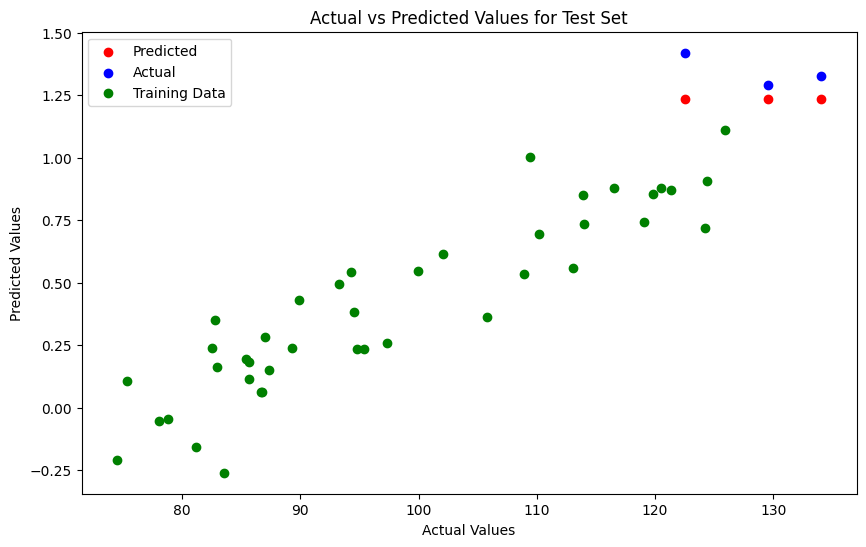

In [7]:

plt.figure(figsize=(10, 6))


plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')


plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
plt.scatter(X_train, y_train, label='Training Data', color='green')

plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


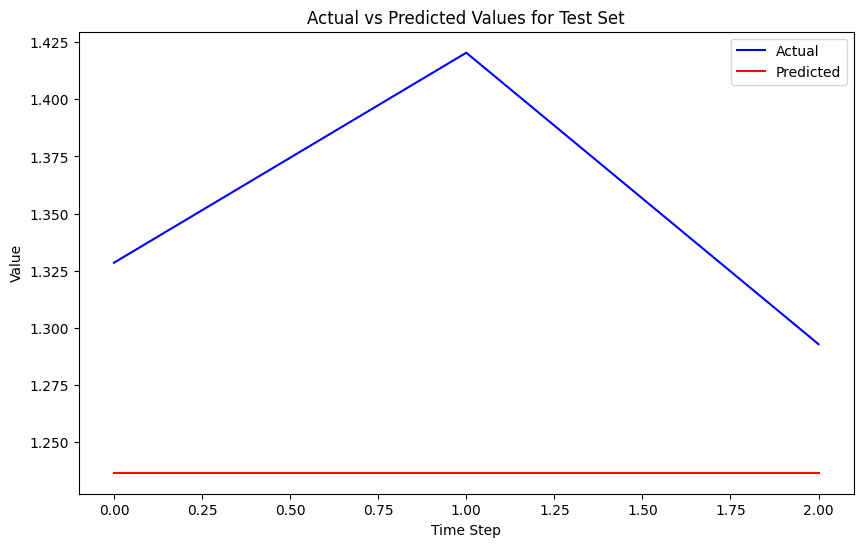

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0076 - mae: 0.1107
Test MAE: 0.11068101972341537
Test loss: 0.0075699579901993275


In [8]:

plt.figure(figsize=(10, 6))
plt.plot(y_test[seq_length:], label='Actual', color='blue')
plt.plot(test_predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Values for Test Set')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()


test_loss, test_mae = deep_model.evaluate(test_ds)
print("Test MAE:", test_mae)
print("Test loss:", test_loss)


model_results = {
    "Test Loss": test_loss,
    "Test MAE": test_mae,
}

In [9]:
test_r2 = r2_score(y_test[seq_length:], test_predictions)

print("Test R^2:", test_r2)

Test R^2: -4.239410278211142


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.2790 - mae: 0.6228 - val_loss: 0.1971 - val_mae: 0.5966
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3274 - mae: 0.6685 - val_loss: 1.5614 - val_mae: 2.0614
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4238 - mae: 0.8085 - val_loss: 1.0707 - val_mae: 1.5707
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2092 - mae: 0.5057 - val_loss: 0.3504 - val_mae: 0.8128
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2781 - mae: 0.5921 - val_loss: 0.7162 - val_mae: 1.2162
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2031 - mae: 0.5188 - val_loss: 0.1940 - val_mae: 0.5889
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3276 - mae: 0.6981 - val_loss: 0.3350 - val_mae: 0.7963
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1604 - mae: 0.4766 - val_loss: 0.8479 - val_mae: 1.3479
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1745 - mae:

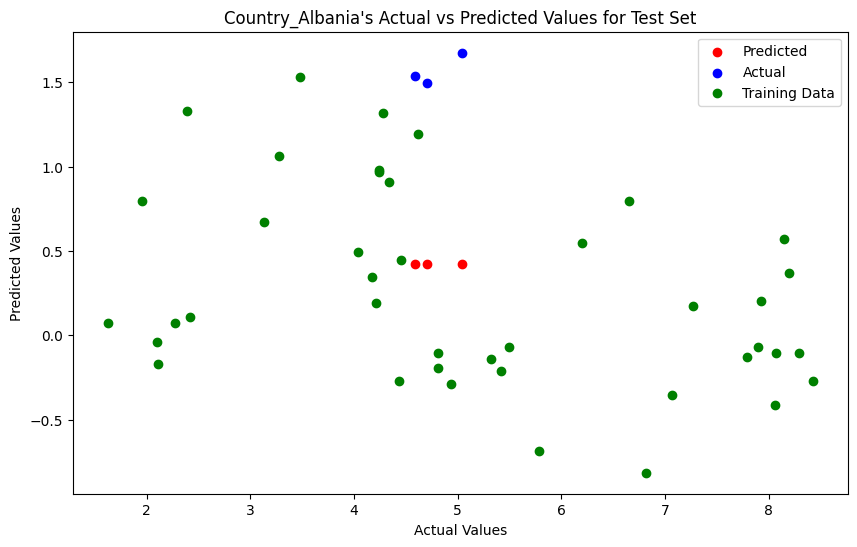

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.2234 - mae: 0.5683 - val_loss: 0.3335 - val_mae: 0.7664
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2229 - mae: 0.5526 - val_loss: 0.7308 - val_mae: 1.2300
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3414 - mae: 0.6962 - val_loss: 0.2578 - val_mae: 0.6593
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2182 - mae: 0.5436 - val_loss: 0.3560 - val_mae: 0.7964
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2370 - mae: 0.5585 - val_loss: 0.5471 - val_mae: 1.0310
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2510 - mae: 0.5857 - val_loss: 0.2375 - val_mae: 0.6278
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2857 - mae: 0.6374 - val_loss: 0.2193 - val_mae: 0.5980
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2566 - mae: 0.5834 - val_loss: 0.6154 - val_mae: 1.1076
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3294 - mae: 

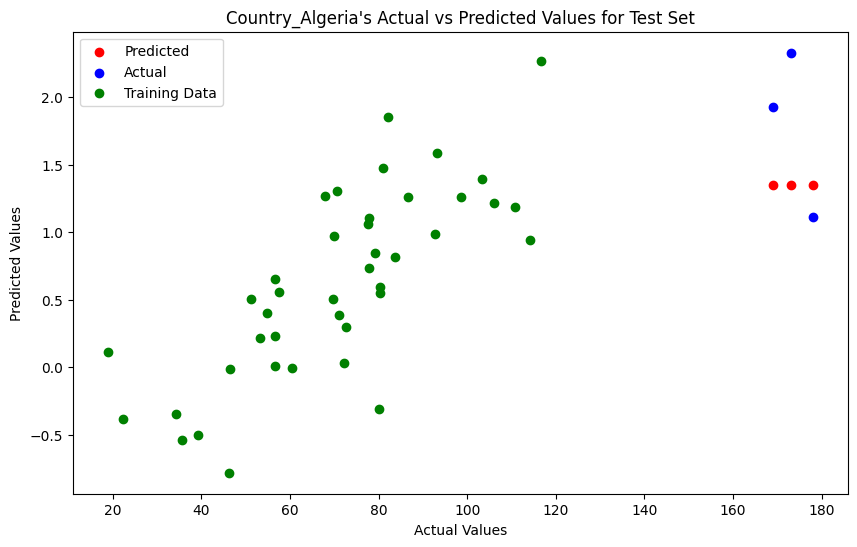

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.1625 - mae: 0.4854 - val_loss: 0.0326 - val_mae: 0.2515
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1728 - mae: 0.4960 - val_loss: 0.0622 - val_mae: 0.2515
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0849 - mae: 0.3405 - val_loss: 0.1786 - val_mae: 0.5422
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1049 - mae: 0.3654 - val_loss: 0.1099 - val_mae: 0.3956
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1007 - mae: 0.3692 - val_loss: 0.0901 - val_mae: 0.3420
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0869 - mae: 0.3441 - val_loss: 0.1731 - val_mae: 0.5320
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1038 - mae: 0.3788 - val_loss: 0.3611 - val_mae: 0.8130
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0803 - mae: 0.3231 - val_loss: 0.3430 - val_mae: 0.7897
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0757 - mae:

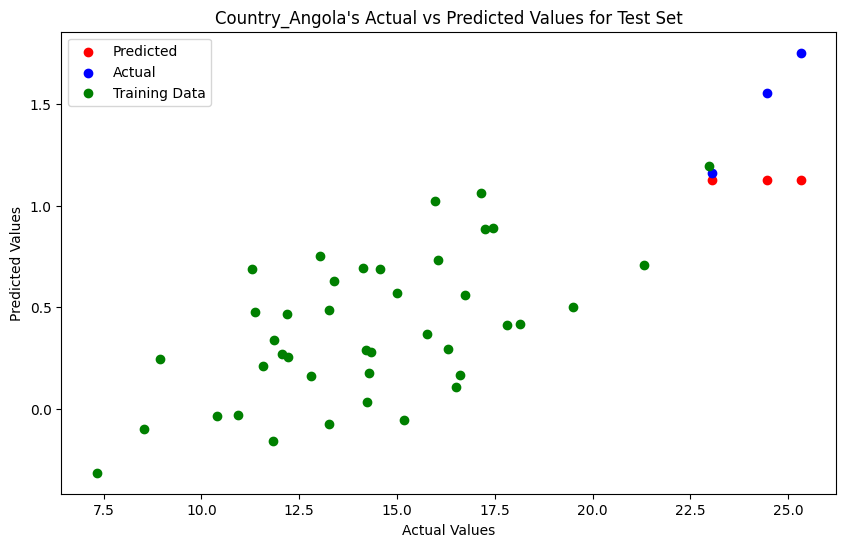

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.1691 - mae: 0.4778 - val_loss: 0.0109 - val_mae: 0.1165
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1468 - mae: 0.4562 - val_loss: 0.1406 - val_mae: 0.5169
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0807 - mae: 0.3172 - val_loss: 0.2520 - val_mae: 0.6999
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0578 - mae: 0.2784 - val_loss: 0.0607 - val_mae: 0.3276
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0674 - mae: 0.2606 - val_loss: 0.2048 - val_mae: 0.6288
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0609 - mae: 0.2909 - val_loss: 0.1148 - val_mae: 0.4642
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0747 - mae: 0.3008 - val_loss: 0.1469 - val_mae: 0.5288
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0684 - mae: 0.2773 - val_loss: 0.1624 - val_mae: 0.5574
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0767 - mae: 

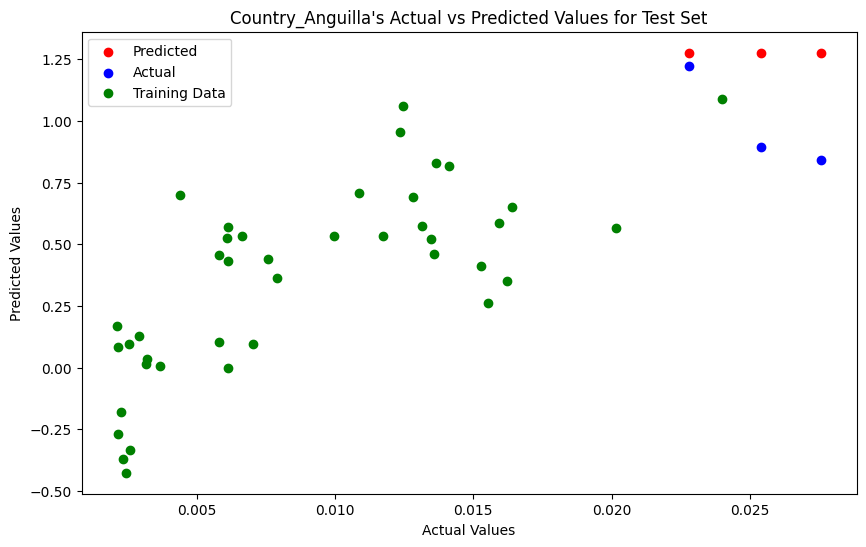

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.2371 - mae: 0.5664 - val_loss: 0.0101 - val_mae: 0.1423
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0976 - mae: 0.3784 - val_loss: 0.0853 - val_mae: 0.3855
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0725 - mae: 0.2960 - val_loss: 0.0404 - val_mae: 0.2420
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0733 - mae: 0.2936 - val_loss: 0.0134 - val_mae: 0.1450
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0518 - mae: 0.2281 - val_loss: 0.0152 - val_mae: 0.1395
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0459 - mae: 0.2453 - val_loss: 0.0466 - val_mae: 0.2729
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0626 - mae: 0.2656 - val_loss: 0.0259 - val_mae: 0.1840
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0474 - mae: 0.2336 - val_loss: 0.0103 - val_mae: 0.1308
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0393 - mae:

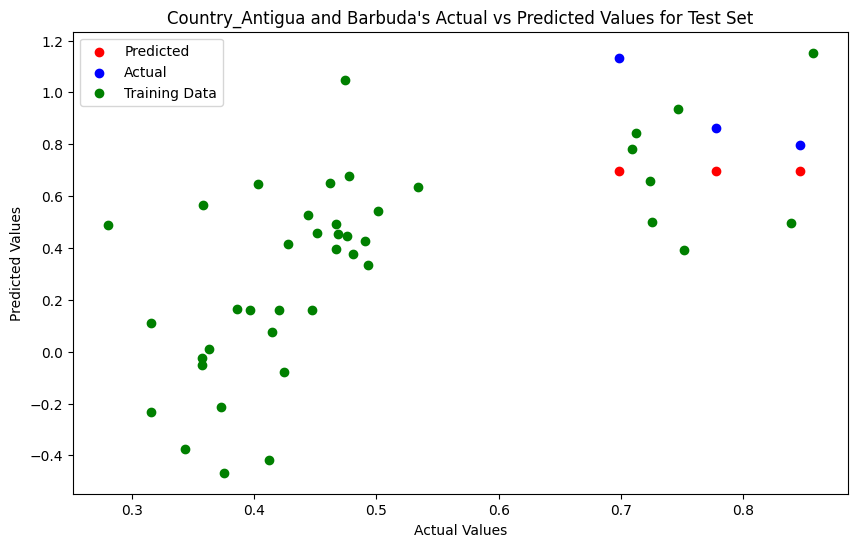

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.0772 - mae: 0.3278 - val_loss: 0.3017 - val_mae: 0.7768
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0519 - mae: 0.2860 - val_loss: 0.3134 - val_mae: 0.7917
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0556 - mae: 0.2981 - val_loss: 0.0708 - val_mae: 0.3764
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0920 - mae: 0.3607 - val_loss: 0.2020 - val_mae: 0.6357
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0483 - mae: 0.2647 - val_loss: 0.2394 - val_mae: 0.6919
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0504 - mae: 0.2308 - val_loss: 0.5521 - val_mae: 1.0521
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0687 - mae: 0.3112 - val_loss: 0.1052 - val_mae: 0.4586
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0767 - mae: 0.3194 - val_loss: 0.2159 - val_mae: 0.6571
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0479 - mae:

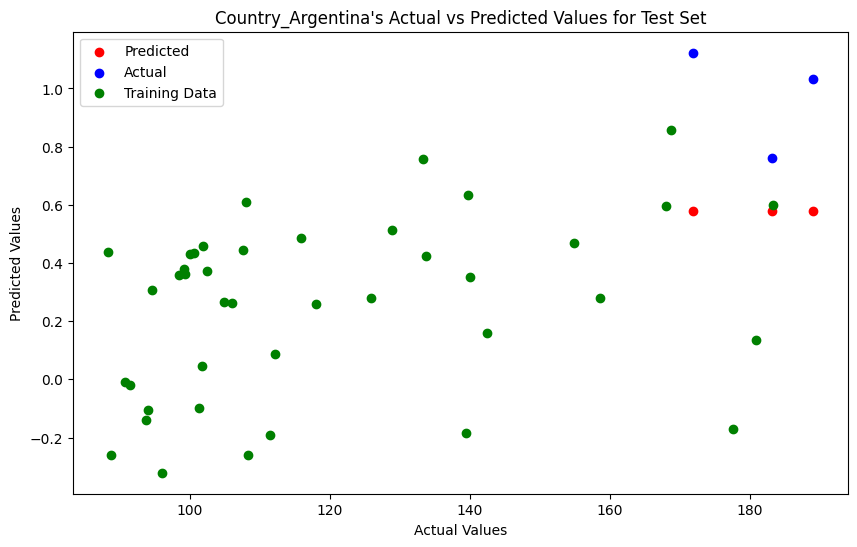

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0693 - mae: 0.2917 - val_loss: 0.2034 - val_mae: 0.6354
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0669 - mae: 0.3027 - val_loss: 0.2249 - val_mae: 0.6684
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0810 - mae: 0.3250 - val_loss: 0.1701 - val_mae: 0.5807
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1091 - mae: 0.3667 - val_loss: 0.1960 - val_mae: 0.6237
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0797 - mae: 0.3026 - val_loss: 0.2356 - val_mae: 0.6842
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0670 - mae: 0.2936 - val_loss: 0.2825 - val_mae: 0.7496
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0850 - mae: 0.3243 - val_loss: 0.1475 - val_mae: 0.5403
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0788 - mae: 0.2978 - val_loss: 0.3373 - val_mae: 0.8195
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0884 - mae:

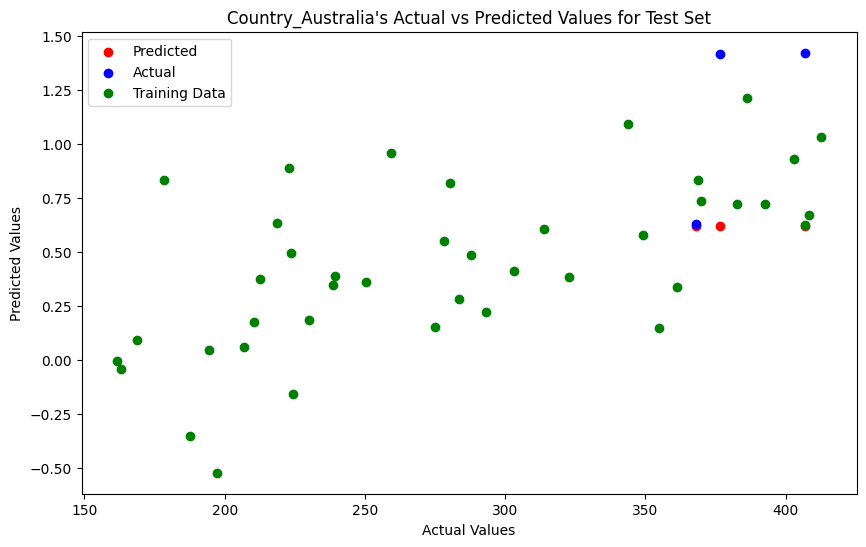

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.2315 - mae: 0.5834 - val_loss: 1.0354 - val_mae: 1.5354
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2680 - mae: 0.6264 - val_loss: 1.0651 - val_mae: 1.5651
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2388 - mae: 0.5640 - val_loss: 1.0379 - val_mae: 1.5379
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2550 - mae: 0.6002 - val_loss: 1.0347 - val_mae: 1.5347
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2417 - mae: 0.6034 - val_loss: 1.2394 - val_mae: 1.7394
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2754 - mae: 0.6361 - val_loss: 0.9808 - val_mae: 1.4808
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1968 - mae: 0.5304 - val_loss: 1.0226 - val_mae: 1.5226
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2325 - mae: 0.5487 - val_loss: 1.2022 - val_mae: 1.7022
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.3080 - mae:

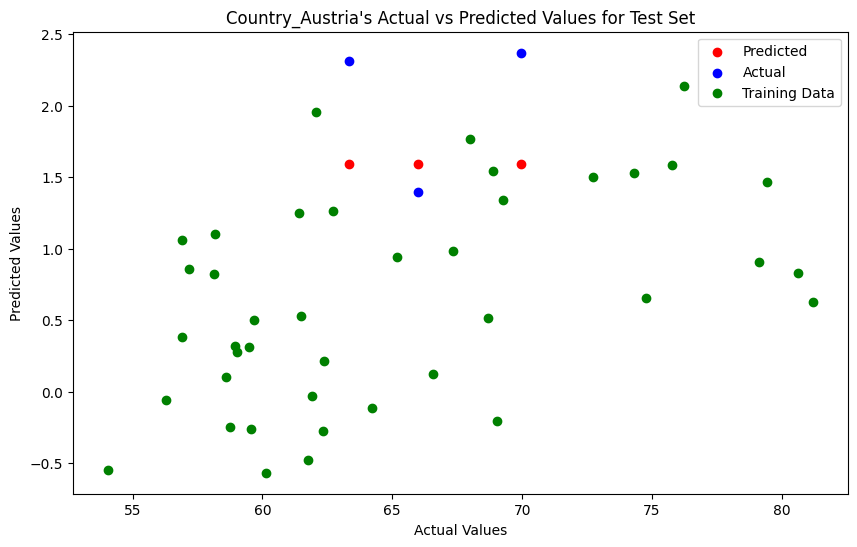

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - loss: 0.1825 - mae: 0.5050 - val_loss: 0.0094 - val_mae: 0.1043
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1357 - mae: 0.4221 - val_loss: 0.0611 - val_mae: 0.3259
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0737 - mae: 0.3070 - val_loss: 0.1177 - val_mae: 0.4716
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0693 - mae: 0.3158 - val_loss: 0.3138 - val_mae: 0.7840
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0570 - mae: 0.2668 - val_loss: 0.1282 - val_mae: 0.4934
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0594 - mae: 0.2842 - val_loss: 0.4460 - val_mae: 0.9377
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0534 - mae: 0.2652 - val_loss: 0.1161 - val_mae: 0.4686
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0613 - mae: 0.3121 - val_loss: 0.2339 - val_mae: 0.6748
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0574 - mae:

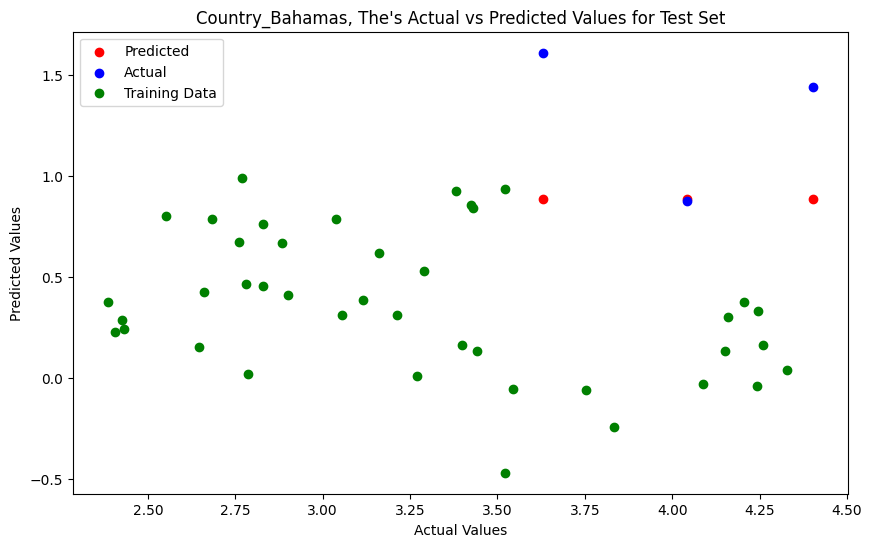

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - loss: 0.1845 - mae: 0.5043 - val_loss: 0.0081 - val_mae: 0.1200
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1095 - mae: 0.3752 - val_loss: 0.0074 - val_mae: 0.1200
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0999 - mae: 0.3738 - val_loss: 0.0884 - val_mae: 0.4029
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0560 - mae: 0.2758 - val_loss: 0.0703 - val_mae: 0.3553
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0639 - mae: 0.2951 - val_loss: 0.0757 - val_mae: 0.3702
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0301 - mae: 0.1716 - val_loss: 0.0269 - val_mae: 0.1987
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0565 - mae: 0.2757 - val_loss: 0.0507 - val_mae: 0.2950
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0420 - mae: 0.2397 - val_loss: 0.0431 - val_mae: 0.2682
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0359 - mae:

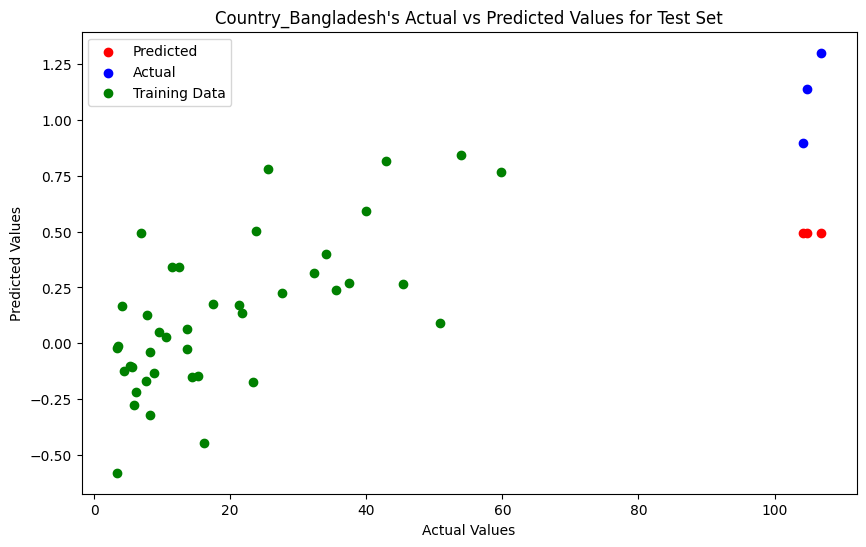

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.0867 - mae: 0.3236 - val_loss: 0.0343 - val_mae: 0.2148
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332 - mae: 0.1880 - val_loss: 0.0219 - val_mae: 0.2076
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0975 - mae: 0.3945 - val_loss: 0.0461 - val_mae: 0.2388
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0687 - mae: 0.2821 - val_loss: 0.0351 - val_mae: 0.2301
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0280 - mae: 0.1674 - val_loss: 0.0552 - val_mae: 0.2427
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460 - mae: 0.2315 - val_loss: 0.0619 - val_mae: 0.2642
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1008 - mae: 0.3659 - val_loss: 0.0266 - val_mae: 0.2277
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0606 - mae: 0.2712 - val_loss: 0.0399 - val_mae: 0.2306
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0486 - mae:

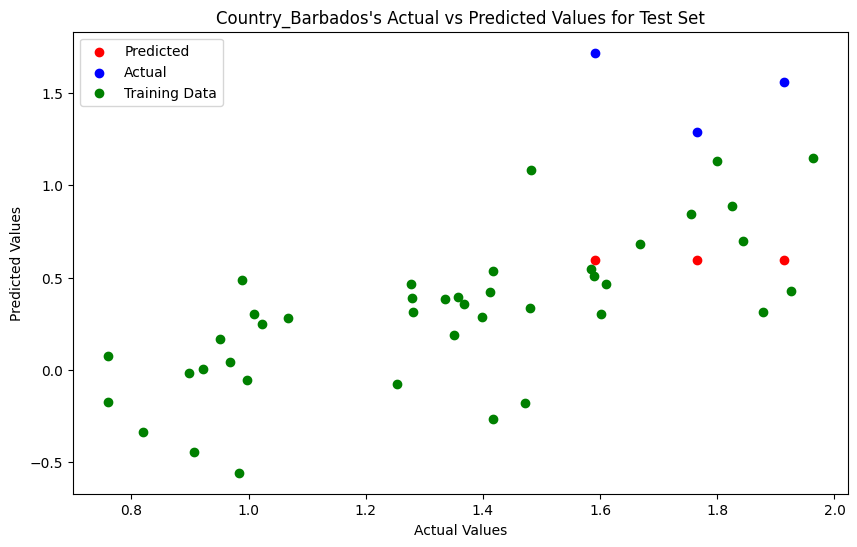

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 0.2977 - mae: 0.6954 - val_loss: 0.6550 - val_mae: 1.1366
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1055 - mae: 0.3798 - val_loss: 0.1444 - val_mae: 0.3999
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0410 - mae: 0.2476 - val_loss: 0.1712 - val_mae: 0.4318
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0371 - mae: 0.1996 - val_loss: 0.0883 - val_mae: 0.3916
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0308 - mae: 0.1939 - val_loss: 0.1277 - val_mae: 0.3944
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479 - mae: 0.2468 - val_loss: 0.1310 - val_mae: 0.3960
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0354 - mae: 0.2160 - val_loss: 0.1022 - val_mae: 0.3950
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0394 - mae: 0.2204 - val_loss: 0.1342 - val_mae: 0.3989
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0291 - mae: 0.2

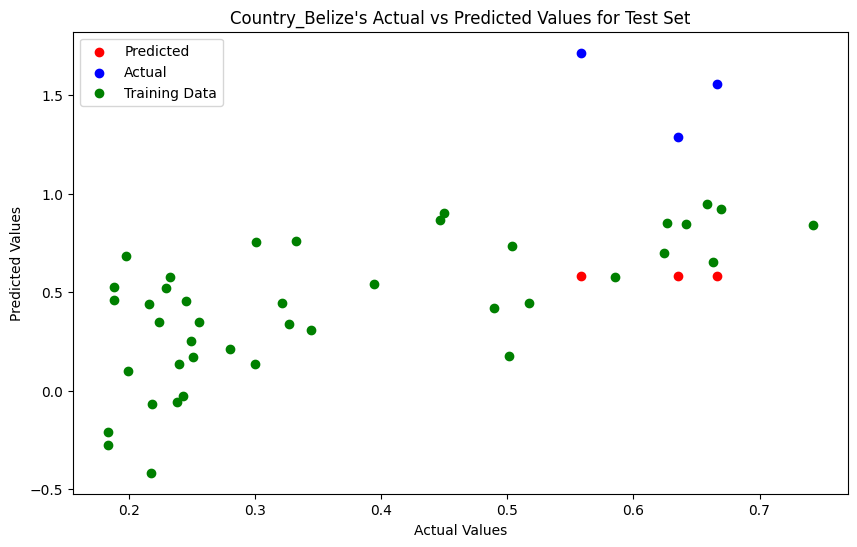

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - loss: 0.0549 - mae: 0.2794 - val_loss: 0.0653 - val_mae: 0.3499
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0492 - mae: 0.2729 - val_loss: 0.0043 - val_mae: 0.0928
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0332 - mae: 0.2181 - val_loss: 0.0105 - val_mae: 0.1115
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0319 - mae: 0.2047 - val_loss: 0.0053 - val_mae: 0.1014
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0317 - mae: 0.2029 - val_loss: 0.0121 - val_mae: 0.1207
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0291 - mae: 0.1883 - val_loss: 0.0078 - val_mae: 0.1006
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0422 - mae: 0.2294 - val_loss: 0.0199 - val_mae: 0.1734
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0368 - mae: 0.2155 - val_loss: 0.0125 - val_mae: 0.1227
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0344 - mae:

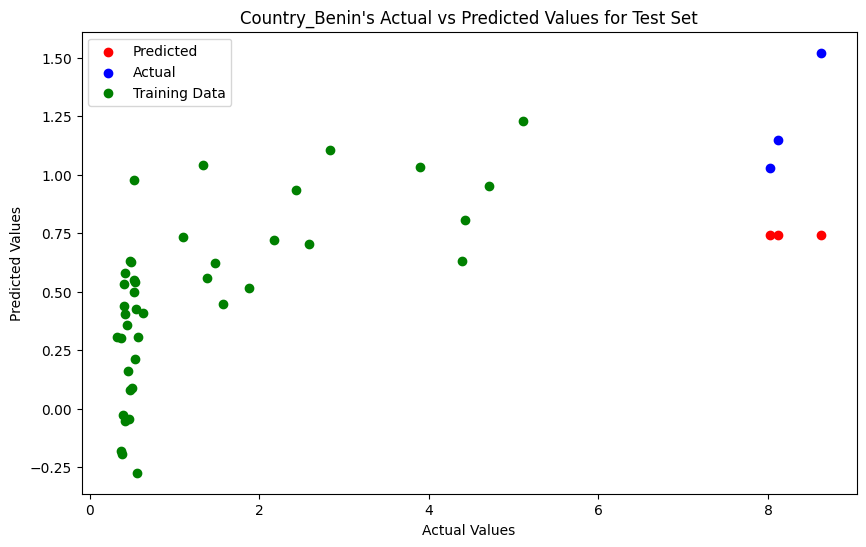

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0570 - mae: 0.2820 - val_loss: 0.0249 - val_mae: 0.1956
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0455 - mae: 0.2490 - val_loss: 0.0538 - val_mae: 0.3093
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0356 - mae: 0.2131 - val_loss: 0.0122 - val_mae: 0.1134
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0403 - mae: 0.2247 - val_loss: 0.0094 - val_mae: 0.1069
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0584 - mae: 0.2840 - val_loss: 0.0705 - val_mae: 0.3584
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0402 - mae: 0.2240 - val_loss: 0.0157 - val_mae: 0.1391
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0449 - mae: 0.2447 - val_loss: 0.0441 - val_mae: 0.2759
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0566 - mae: 0.2955 - val_loss: 0.0221 - val_mae: 0.1787
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0302 - mae:

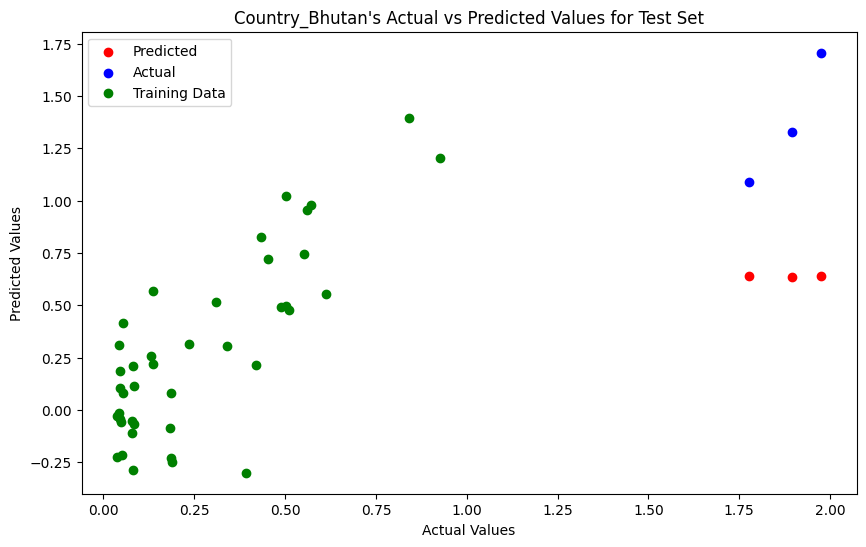

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0725 - mae: 0.3346 - val_loss: 0.4131 - val_mae: 0.8706
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0437 - mae: 0.2411 - val_loss: 0.3310 - val_mae: 0.7617
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0365 - mae: 0.2169 - val_loss: 0.1688 - val_mae: 0.5047
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0398 - mae: 0.2396 - val_loss: 0.2131 - val_mae: 0.5864
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0268 - mae: 0.1909 - val_loss: 0.1959 - val_mae: 0.5554
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0212 - mae: 0.1560 - val_loss: 0.1837 - val_mae: 0.5331
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0308 - mae: 0.2074 - val_loss: 0.2020 - val_mae: 0.5659
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0282 - mae: 0.1832 - val_loss: 0.1720 - val_mae: 0.5103
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - mae:

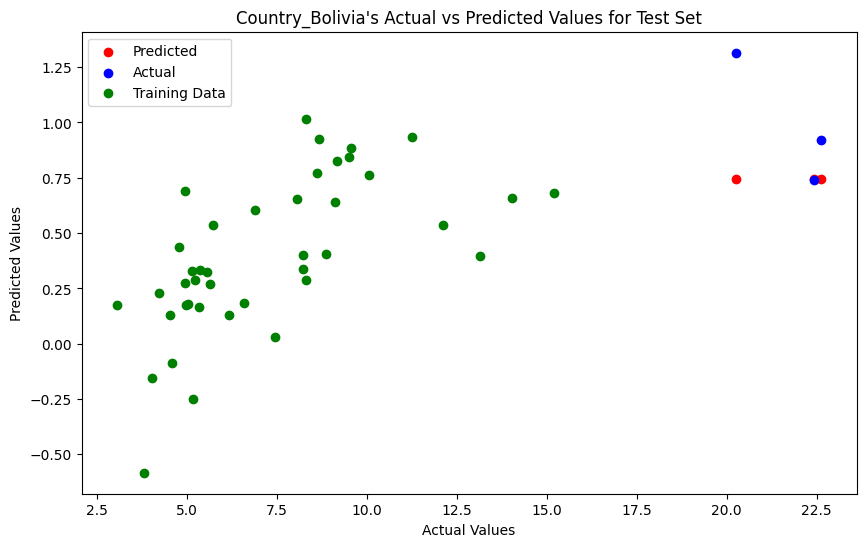

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.1733 - mae: 0.4890 - val_loss: 0.3721 - val_mae: 0.7592
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1460 - mae: 0.4596 - val_loss: 0.4409 - val_mae: 0.8170
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1237 - mae: 0.4116 - val_loss: 0.4818 - val_mae: 0.8294
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1043 - mae: 0.3551 - val_loss: 0.4470 - val_mae: 0.8669
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1311 - mae: 0.4129 - val_loss: 0.4981 - val_mae: 0.8358
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1288 - mae: 0.4274 - val_loss: 0.4239 - val_mae: 0.8358
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1428 - mae: 0.4619 - val_loss: 0.5304 - val_mae: 0.8094
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1843 - mae: 0.4927 - val_loss: 0.4198 - val_mae: 0.8446
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1328 - mae:

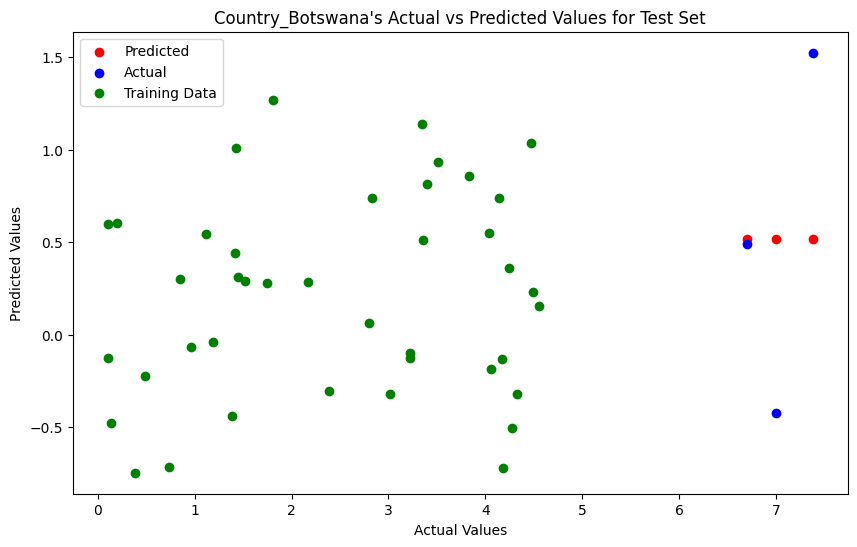

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - loss: 0.0711 - mae: 0.3023 - val_loss: 0.4330 - val_mae: 0.9153
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0547 - mae: 0.2635 - val_loss: 0.3328 - val_mae: 0.7954
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0640 - mae: 0.2838 - val_loss: 0.4138 - val_mae: 0.8930
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0624 - mae: 0.2841 - val_loss: 0.2877 - val_mae: 0.7365
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0660 - mae: 0.2827 - val_loss: 0.4218 - val_mae: 0.9024
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0649 - mae: 0.2980 - val_loss: 0.3382 - val_mae: 0.8021
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0727 - mae: 0.3014 - val_loss: 0.3796 - val_mae: 0.8525
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0677 - mae: 0.2876 - val_loss: 0.3725 - val_mae: 0.8440
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0644 - mae:

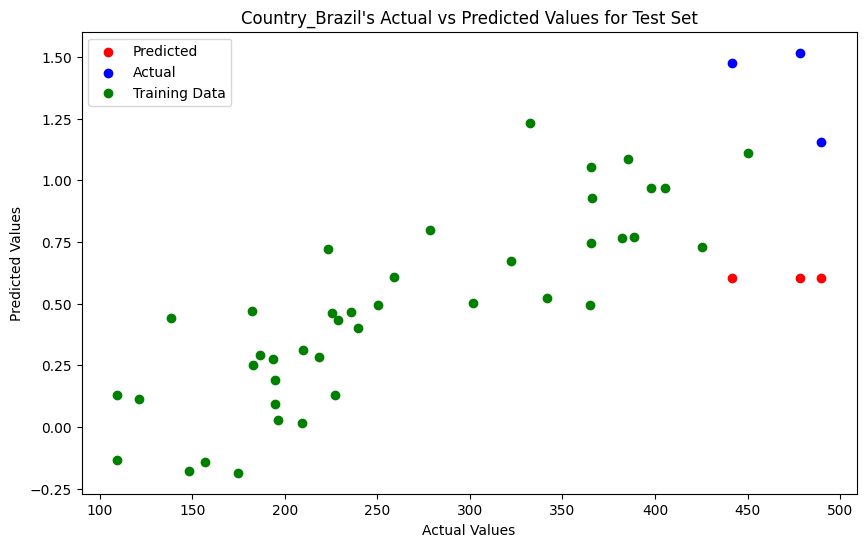

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 0.0665 - mae: 0.2865 - val_loss: 0.1002 - val_mae: 0.4401
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0570 - mae: 0.2856 - val_loss: 0.0353 - val_mae: 0.2526
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0529 - mae: 0.2596 - val_loss: 0.0097 - val_mae: 0.1142
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0503 - mae: 0.2593 - val_loss: 0.0037 - val_mae: 0.0847
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0530 - mae: 0.2440 - val_loss: 0.0058 - val_mae: 0.0862
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0479 - mae: 0.2649 - val_loss: 0.0048 - val_mae: 0.0899
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0459 - mae: 0.2369 - val_loss: 0.0046 - val_mae: 0.0921
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0496 - mae: 0.2514 - val_loss: 0.0086 - val_mae: 0.0946
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0472 - mae:

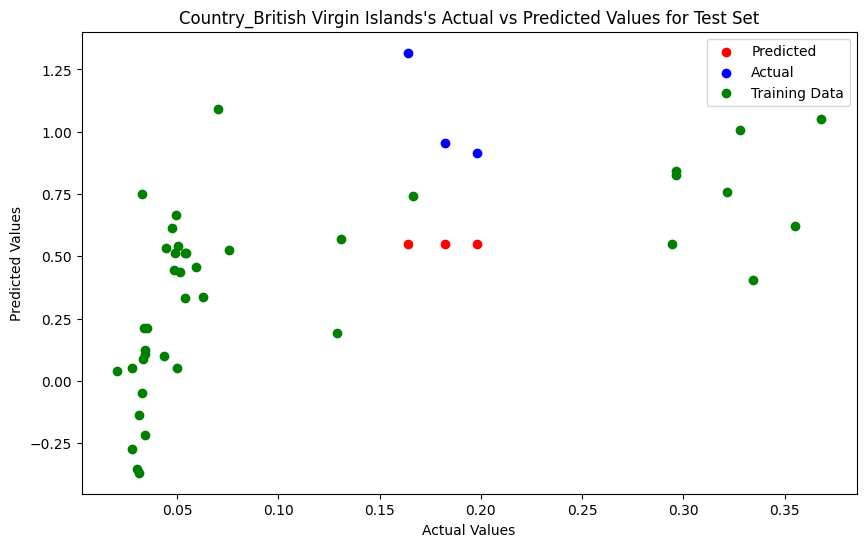

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.1787 - mae: 0.4730 - val_loss: 0.7064 - val_mae: 1.2064
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2192 - mae: 0.5076 - val_loss: 0.3327 - val_mae: 0.8067
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2062 - mae: 0.5164 - val_loss: 0.6386 - val_mae: 1.1386
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2093 - mae: 0.5424 - val_loss: 0.3684 - val_mae: 0.8498
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2646 - mae: 0.6113 - val_loss: 0.8201 - val_mae: 1.3201
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2767 - mae: 0.5959 - val_loss: 0.7589 - val_mae: 1.2589
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2331 - mae: 0.5427 - val_loss: 0.1553 - val_mae: 0.5441
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2387 - mae: 0.5861 - val_loss: 0.7921 - val_mae: 1.2921
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2305 - mae:

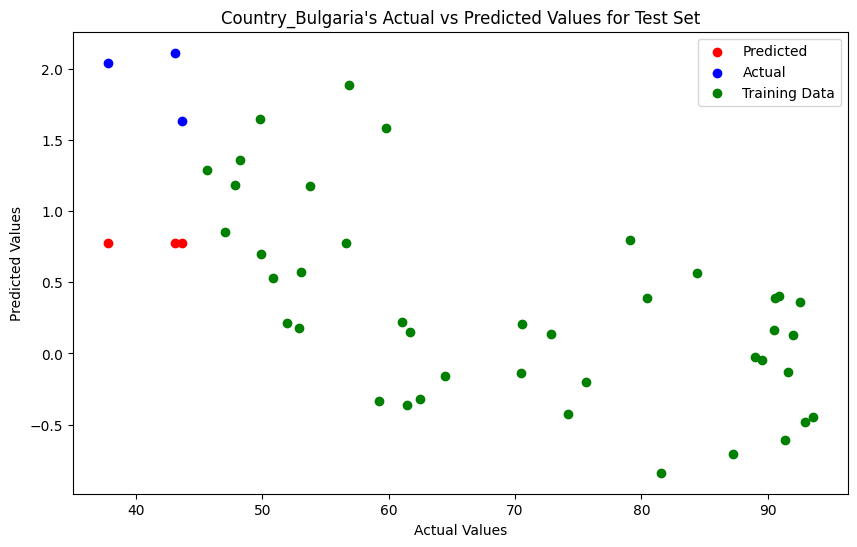

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.0638 - mae: 0.2883 - val_loss: 0.0189 - val_mae: 0.1460
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0469 - mae: 0.2515 - val_loss: 0.0065 - val_mae: 0.1085
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0667 - mae: 0.2989 - val_loss: 0.0136 - val_mae: 0.1382
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0620 - mae: 0.3015 - val_loss: 0.0144 - val_mae: 0.1305
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0598 - mae: 0.2731 - val_loss: 0.0489 - val_mae: 0.2905
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0464 - mae: 0.2482 - val_loss: 0.0109 - val_mae: 0.1080
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0648 - mae: 0.2930 - val_loss: 0.0533 - val_mae: 0.3117
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0700 - mae: 0.3202 - val_loss: 0.0163 - val_mae: 0.1509
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0601 - mae:

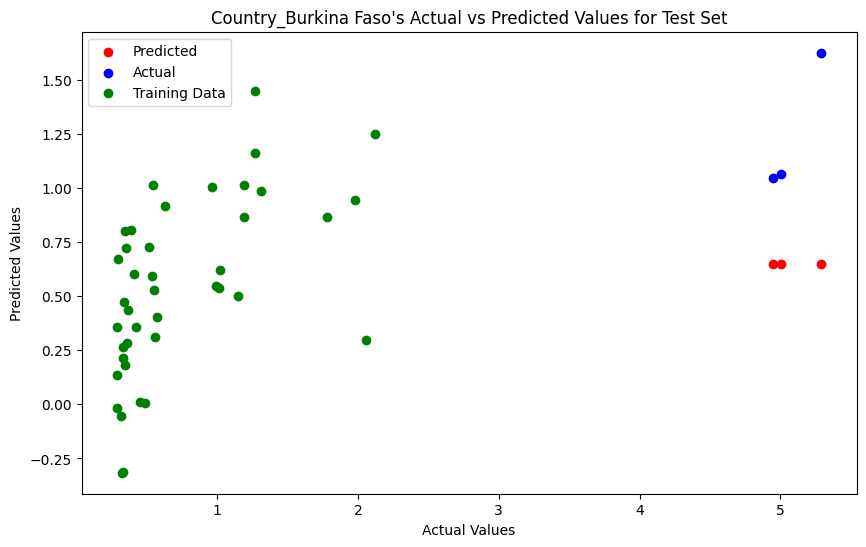

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.3102 - mae: 0.6223 - val_loss: 0.1320 - val_mae: 0.5122
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1314 - mae: 0.4207 - val_loss: 0.0516 - val_mae: 0.3209
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1847 - mae: 0.4723 - val_loss: 0.0083 - val_mae: 0.1249
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1893 - mae: 0.4986 - val_loss: 7.7021e-04 - val_mae: 0.0392
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1489 - mae: 0.4174 - val_loss: 0.0049 - val_mae: 0.0924
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1864 - mae: 0.5138 - val_loss: 0.0034 - val_mae: 0.0750
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1609 - mae: 0.4493 - val_loss: 0.0092 - val_mae: 0.1310
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1333 - mae: 0.4227 - val_loss: 7.0831e-04 - val_mae: 0.0340
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.178

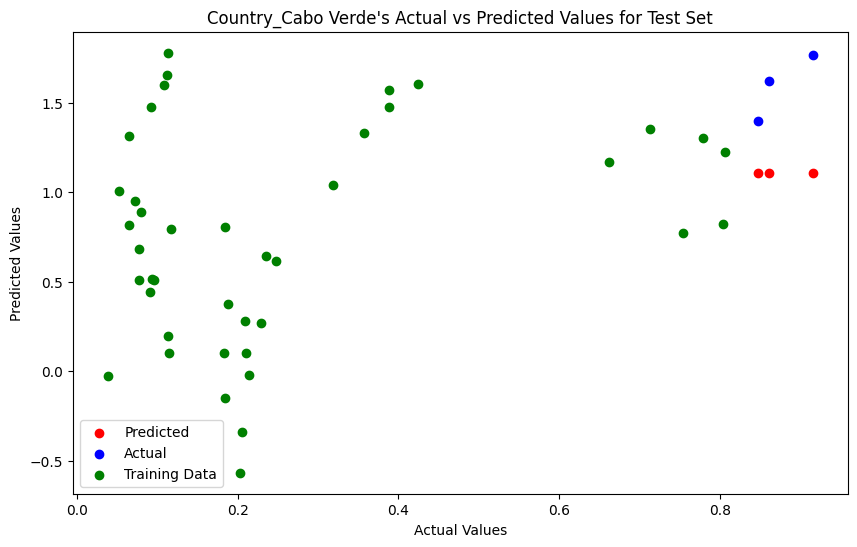

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.1435 - mae: 0.4248 - val_loss: 0.0644 - val_mae: 0.2701
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0649 - mae: 0.2909 - val_loss: 0.0692 - val_mae: 0.2775
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0557 - mae: 0.2613 - val_loss: 0.0263 - val_mae: 0.2293
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0358 - mae: 0.2105 - val_loss: 0.0273 - val_mae: 0.2319
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0559 - mae: 0.2788 - val_loss: 0.0362 - val_mae: 0.2274
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0260 - mae: 0.1703 - val_loss: 0.0270 - val_mae: 0.2294
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0354 - mae: 0.2012 - val_loss: 0.0302 - val_mae: 0.2247
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0465 - mae: 0.2308 - val_loss: 0.0270 - val_mae: 0.2258
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0308 - mae:

In [ ]:
for country in df.columns[3:]:

  if df[country].sum() == 52:

    country_data = df[df[country] == 1][['Year', 'Temperature', 'Co2']]

    X = country_data[['Co2']].values
    y = country_data['Temperature'].values

    split_index = int(len(X) * 0.8)

    X_train, X_val_test = X[:split_index], X[split_index:]
    y_train, y_val_test = y[:split_index], y[split_index:]


    split_index_val = int(len(X_val_test) * 0.5)

    X_val, X_test = X_val_test[:split_index_val], X_val_test[split_index_val:]
    y_val, y_test = y_val_test[:split_index_val], y_val_test[split_index_val:]


    seq_length = 3
    tf.random.set_seed(42)

    train_ds = keras.utils.timeseries_dataset_from_array(
        X_train,
        targets = y_train[seq_length:],
        sequence_length= seq_length,
        batch_size = 5,
        shuffle = True,
        seed = 42
    )

    valid_ds = keras.utils.timeseries_dataset_from_array(
        X_val,
        targets= y_val[seq_length:],
        sequence_length = seq_length,
        batch_size = 32
    )

    model = fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.05)

    test_predictions = deep_model.predict(test_ds)

    plt.figure(figsize=(10, 6))

    plt.scatter(X_test[seq_length:], test_predictions, color='red', label='Predicted')
    plt.scatter(X_test[seq_length:], y_test[seq_length:], color='blue', label='Actual')
    plt.scatter(X_train, y_train, label='Training Data', color='green')

    plt.title(f"{country}'s Actual vs Predicted Values for Test Set")
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()
    